# Final Project: Task 2 - Biodiversity Intactness Index Change in Phoenix, AZ

## **About**

- Purpose: 

- Highlights:

    - 

- Data: 


**References**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from janitor import clean_names
import planetary_computer
from pystac_client import Client
import contextily as ctx

/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/planetary_computer/sas.py:40: PydanticDeprecatedSince20: Support for class-based `config` is deprecated, use ConfigDict instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.12/migration/
  class SASBase(BaseModel):


In [2]:
# Read Arizona shapefile
path = os.path.join('data', 'tl_2024_04_cousub', 'tl_2024_04_cousub.shp')
arizona = gpd.read_file(path)

In [3]:
# Access MPC catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Set search parameters
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]
dates = "2017-01-01/2021-01-01"

# Search MPC catalog
search = catalog.search(collections=["io-biodiversity"], bbox=bbox, datetime=dates)
items = search.item_collection()

In [4]:
items[0]

<Item id=bii_2020_34.74464974521749_-115.38597824385106_cog>

In [5]:
for item in items:
    print(item.properties['start_datetime'])

2020-01-01T00:00:00Z
2019-01-01T00:00:00Z
2018-01-01T00:00:00Z
2017-01-01T00:00:00Z


In [6]:
print(items[3].properties['start_datetime'])
print(items[0].properties['start_datetime'])

2017-01-01T00:00:00Z
2020-01-01T00:00:00Z


In [7]:
biodiv_2017 = rioxr.open_rasterio(items[3].assets["data"].href)
biodiv_2020 = rioxr.open_rasterio(items[0].assets["data"].href)

/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/Users/zachloo/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


<Axes: >

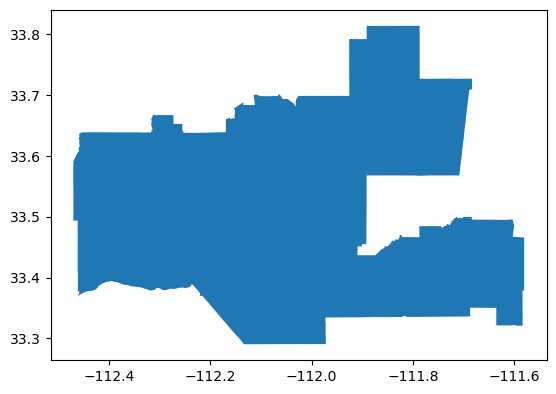

In [8]:
phoenix = arizona[arizona['NAME'] == "Phoenix"]
phoenix.plot()

In [9]:
phoenix.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

In [10]:
print(biodiv_2017.spatial_ref.crs_wkt)
print(biodiv_2017.rio.bounds())

GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
(-115.38597824385106, 27.56531399453427, -108.20664249316783, 34.74464974521749)


In [11]:
biodiv_2017.rio.write_crs(biodiv_2017.spatial_ref.crs_wkt, inplace=True)
print(biodiv_2017.rio.crs)

EPSG:4326


In [12]:
phoenix = phoenix.to_crs("EPSG:4326")
print(phoenix.crs)

EPSG:4326


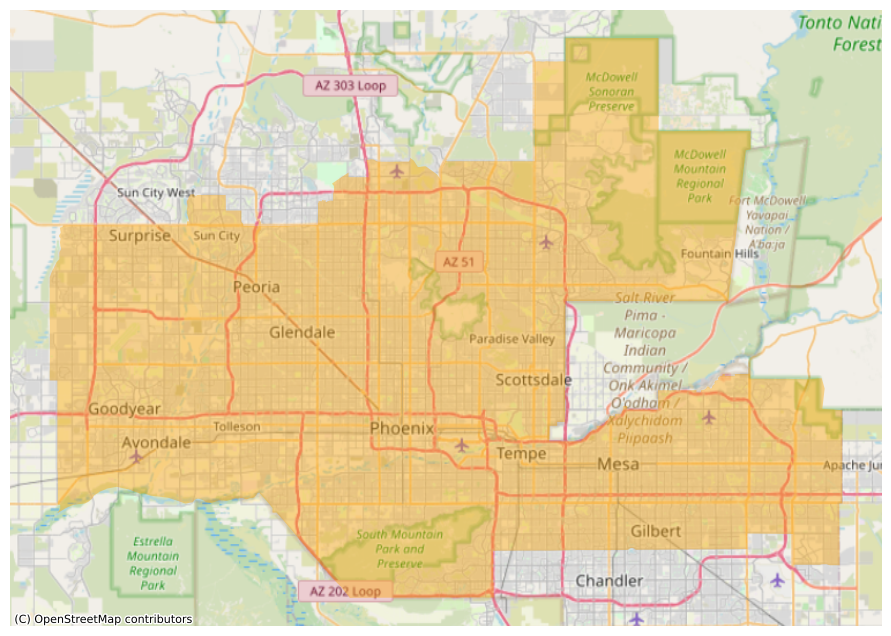

In [13]:
fig, ax = plt.subplots(figsize=(15, 8))

phoenix.plot(ax=ax, alpha=0.4, color='orange')

ax.axis('off')

# Add basemap using contextily
ctx.add_basemap(ax, crs=phoenix.crs, source=ctx.providers.OpenStreetMap.Mapnik)

plt.show()

In [14]:
biodiv_2017_clip = biodiv_2017.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)
biodiv_2020_clip = biodiv_2020.rio.clip_box(*phoenix.total_bounds).rio.clip(phoenix.geometry)

In [15]:
# Calculate percentages of high BII for 2017 & 2020
high_bii_2017 = biodiv_2017_clip >= 0.75
pct_2017 = (high_bii_2017.sum() / biodiv_2017_clip.count()) * 100

high_bii_2020 = biodiv_2020_clip >= 0.75
pct_2020 = (high_bii_2020.sum() / biodiv_2020_clip.count()) * 100

print(f"High BII Percentage in 2017: {pct_2017.values:.2f}%")
print(f"High BII Percentage in 2020: {pct_2020.values:.2f}%")

High BII Percentage in 2017: 7.13%
High BII Percentage in 2020: 6.49%


Create a visualization showing the area with BII>=0.75 in 2017 that was lost by 2020.

- Right now in high_bii_2017 & high_bii_2020 arrays, `True` if BII >= 0.75.
- We want cells where high_bii_2017 == `True` *and* high_bii_2020 == `False`
- Using `~` on `high_bii_2020`, boolean values are inverted
- Combined with the `&` operator, the resulting DataArray is True where cells meet both conditions, indicating a drop in BII

In [16]:
bii_loss = high_bii_2017 & (~high_bii_2020)

# Assign 0 to nan
bii_loss_masked = bii_loss.where(bii_loss != 0)

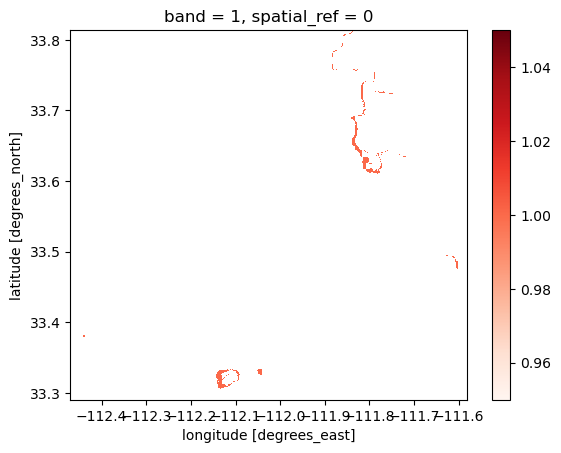

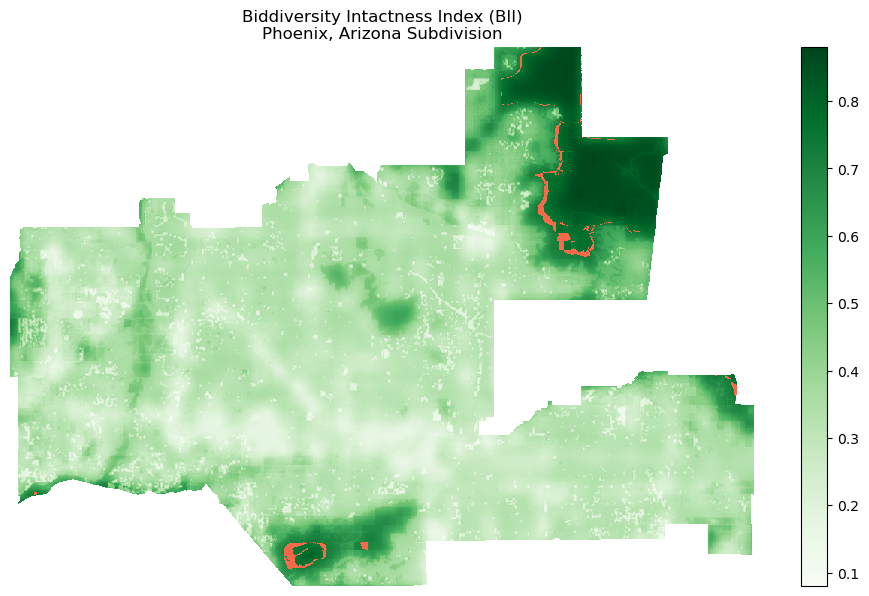

In [31]:
fig, ax = plt.subplots(figsize=(12, 7)) 

ax.axis('off')

biodiv_2020_clip.plot(ax=ax, cmap="Greens")
bii_loss_masked.plot(ax=ax, cmap='Reds', 
                     add_colorbar=False)
plt.title("Biddiversity Intactness Index (BII)\nPhoenix, Arizona Subdivision")
plt.show()